# Fraud Detection in Financial Transactions

The goal of this project is to **detect fraudulent transactions** in a dataset of financial transactions. The project aims to:

1. Identify fraudulent transactions using machine learning techniques.
2. Understand patterns that distinguish fraudulent transactions from legitimate ones.
3. Build a predictive model that can flag potentially fraudulent transactions in real-time.

The dataset contains information about transactions, including:

    Transaction details: Amount, type (e.g., PAYMENT, CASH_OUT, TRANSFER), and balances before and after the transaction.

    Fraud indicator: A column (isFraud) that labels whether a transaction is fraudulent or not.

## 1. Load the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  # For handling class imbalance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = 'PS_20174392719_1491204439457_log.csv'
df = pd.read_csv(file_path)

# Display the first few rows
print("\nFirst few rows:")
df.head()


First few rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


##  2. Exploratory Data Analysis (EDA) for Fraud Detection

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

Missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Summary statistics:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02 

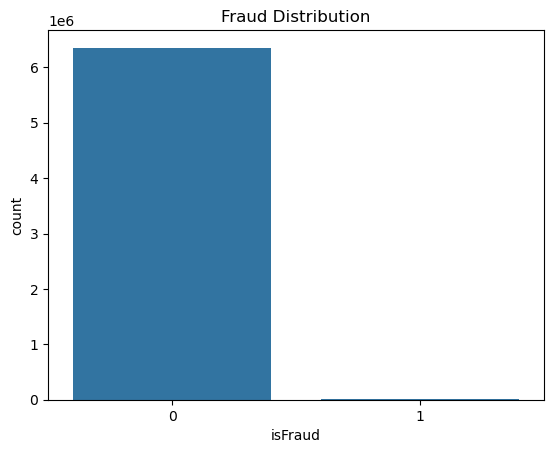

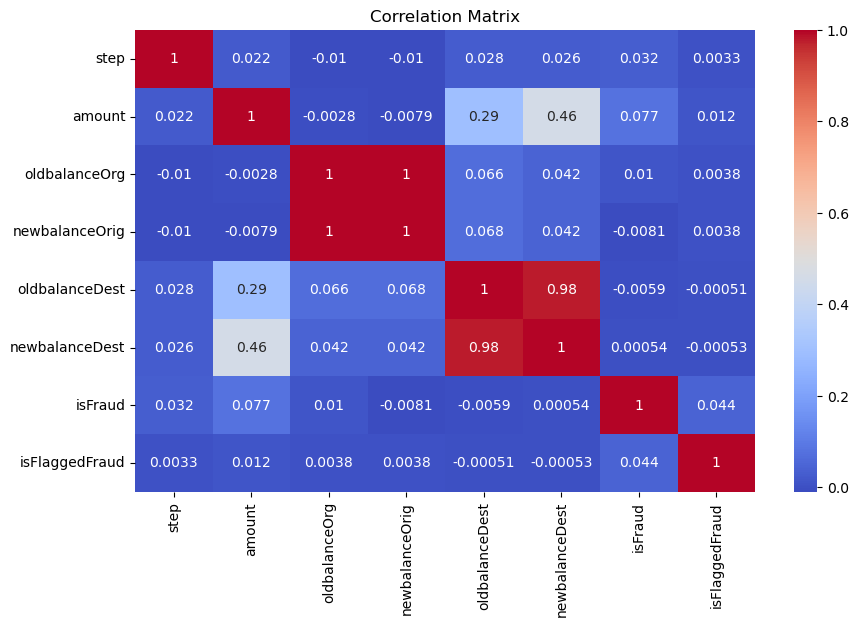

In [2]:
# Display basic information
print("Dataset Info:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Summary statistics for numerical columns
print("\nSummary statistics:")
print(df.describe())

# Distribution of the target variable (assuming 'isFraud' is the fraud indicator)
if 'isFraud' in df.columns:
    print("\nDistribution of fraud cases:")
    print(df['isFraud'].value_counts())
    sns.countplot(x='isFraud', data=df)
    plt.title('Fraud Distribution')
    plt.show()

# Correlation matrix for numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns
if len(numerical_features) > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

## 3. Feature Engineering

Create new features that can help the model better distinguish between fraudulent and non-fraudulent transactions. These features capture important patterns in the data, such as unusual changes in account balances or disproportionately large transactions, which are often associated with fraud.

In [3]:
# 1. Balance Change for Origin Account
df['balance_change_org'] = df['oldbalanceOrg'] - df['newbalanceOrig']

# 2. Balance Change for Destination Account
df['balance_change_dest'] = df['oldbalanceDest'] - df['newbalanceDest']

# 3. Transaction Ratio (Amount vs. Origin Balance)
df['transaction_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1e-9)  # Add small constant to avoid division by zero

# 4. Transaction Type Encoding (One-Hot Encoding)
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# 5. Flag Large Transactions (if needed)
df['is_large_transaction'] = (df['amount'] > 200000).astype(int)

# Display new features
print("\nNew features:")
print(df[['balance_change_org', 'balance_change_dest', 'transaction_ratio', 'is_large_transaction']].head())


New features:
   balance_change_org  balance_change_dest  transaction_ratio  \
0             9839.64                  0.0           0.057834   
1             1864.28                  0.0           0.087735   
2              181.00                  0.0           1.000000   
3              181.00              21182.0           1.000000   
4            11668.14                  0.0           0.280795   

   is_large_transaction  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  


In [4]:
# Prepare features and target
# Features (X)
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
            'balance_change_org', 'balance_change_dest', 'transaction_ratio', 'is_large_transaction']
# Add one-hot encoded columns for transaction type
features += [col for col in df.columns if col.startswith('type_')]

X = df[features]
y = df['isFraud']  # Target variable

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled = pd.DataFrame(X_scaled, columns=features)

# Display the cleaned and preprocessed data
print("\nCleaned and preprocessed data:")
print(X_scaled.head())


Cleaned and preprocessed data:
     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0 -0.281560      -0.229810       -0.237622       -0.323814       -0.333411   
1 -0.294767      -0.281359       -0.285812       -0.323814       -0.333411   
2 -0.297555      -0.288654       -0.292442       -0.323814       -0.333411   
3 -0.297555      -0.288654       -0.292442       -0.317582       -0.333411   
4 -0.278532      -0.274329       -0.282221       -0.323814       -0.333411   

   balance_change_org  balance_change_dest  transaction_ratio  \
0            0.211876             0.152896          -0.138863   
1            0.157490             0.152896          -0.138863   
2            0.146011             0.152896          -0.138863   
3            0.146011             0.178952          -0.138863   
4            0.224345             0.152896          -0.138863   

   is_large_transaction  type_CASH_OUT  type_DEBIT  type_PAYMENT  \
0              -0.59742      -0.736484  

## 4. Classification Model for Fraud Detection

In [5]:
# Classification Model for Fraud Detection

# Handle missing values (if any)
X = X.fillna(X.median())
y = y.fillna(0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [6]:
# Train a Random Forest model
model = RandomForestClassifier(random_state=42, class_weight='balanced')  # Use class weights to handle imbalance

In [7]:
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [8]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

The classification model learns patterns in the data to predict fraud. Metrics like precision, recall, and ROC-AUC help assess how well the model performs.


Confusion Matrix:
[[1906133     218]
 [     10    2425]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.92      1.00      0.96      2435

    accuracy                           1.00   1908786
   macro avg       0.96      1.00      0.98   1908786
weighted avg       1.00      1.00      1.00   1908786


ROC-AUC Score:
0.9985405437223829

Precision-Recall AUC: 0.9893986144289276


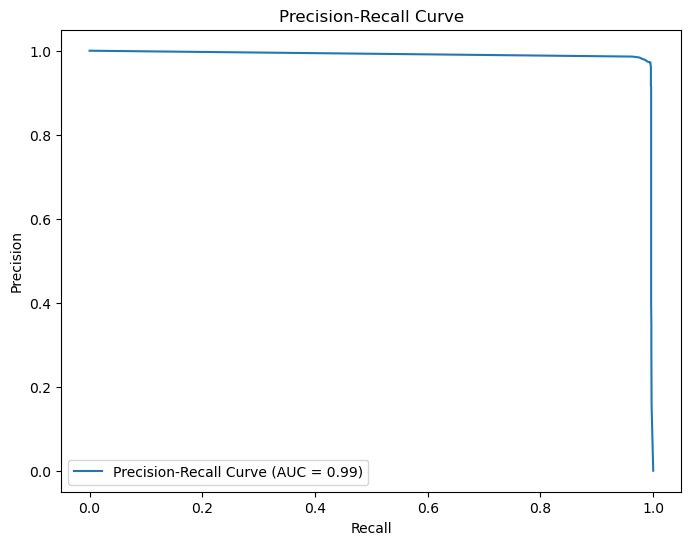

In [9]:
# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

#### Interpretation

- The Precision-Recall AUC is more informative than ROC-AUC for imbalanced datasets because it focuses on the minority class (fraudulent transactions).
- A score of 0.9894 is very close to 1, indicating excellent performance.
- The model performs well even when focusing on the minority class, which is critical for fraud detectio

### 5. Feature Importance

In [10]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
print("\nFeature Importance:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))


Feature Importance:
                 Feature  Importance
7      transaction_ratio    0.330566
5     balance_change_org    0.284283
2         newbalanceOrig    0.117115
1          oldbalanceOrg    0.067280
0                 amount    0.051716
6    balance_change_dest    0.035043
11          type_PAYMENT    0.034322
12         type_TRANSFER    0.031691
8   is_large_transaction    0.013065
4         newbalanceDest    0.013026
9          type_CASH_OUT    0.011366
3         oldbalanceDest    0.010334
10            type_DEBIT    0.000192


#### Interpretation

- The transaction_ratio and balance_change_org are the most critical features for detecting fraud. This suggests that unusual changes in account balances or disproportionately large transactions are strong indicators of fraud.
- Features like type_DEBIT and oldbalanceDest have very low importance, meaning they contribute little to the model’s predictions.

### 6. Anomaly Detection

In [14]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Adjust the contamination parameter (lower value reduces false positives)
contamination = 0.005  # Adjust based on domain knowledge or expected fraud rate

# Prepare features for anomaly detection
# Focus on the most relevant features
anomaly_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
                    'balance_change_org', 'balance_change_dest', 'transaction_ratio']

X_anomaly = df[anomaly_features]

# Fit the Isolation Forest model with adjusted contamination
iso_forest = IsolationForest(contamination=contamination, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(X_anomaly)

# Mark anomalies
df['is_anomaly'] = np.where(df['anomaly_score'] == -1, 1, 0)

# Display anomalies
print("\nAnomalies detected:")
print(df[df['is_anomaly'] == 1].head())

# Compare anomalies with actual fraud labels (if available)
if 'isFraud' in df.columns:
    print("\nComparison of detected anomalies with actual fraud cases:")
    print(pd.crosstab(df['is_anomaly'], df['isFraud'], rownames=['Anomaly Detected'], colnames=['Actual Fraud']))

# Evaluate anomaly detection performance
if 'isFraud' in df.columns:
    from sklearn.metrics import classification_report

    print("\nAnomaly Detection Performance:")
    print(classification_report(df['isFraud'], df['is_anomaly']))

# Add anomaly score as a feature to the classification model
df['anomaly_score'] = iso_forest.decision_function(X_anomaly)  # Use decision function for continuous scores

# Prepare features and target for classification
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
            'balance_change_org', 'balance_change_dest', 'transaction_ratio', 'anomaly_score']
# Add one-hot encoded columns for transaction type
features += [col for col in df.columns if col.startswith('type_')]

X = df[features]
y = df['isFraud']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("\nClassification Report (with Anomaly Score):")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix (with Anomaly Score):")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score (with Anomaly Score):")
print(roc_auc_score(y_test, y_pred_proba))


Anomalies detected:
     step      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
89      1  1429051.47  C1520267010            0.0             0.0   
94      1  1724887.05  C1495608502            0.0             0.0   
358     1  1538200.39   C476579021            0.0             0.0   
359     1  2421578.09   C106297322            0.0             0.0   
362     1  1457213.54   C396918327            0.0             0.0   

        nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
89   C1590550415      2041543.62     19169204.93        0               0   
94   C1590550415      3470595.10     19169204.93        0               0   
358  C1590550415      6977445.38     19169204.93        0               0   
359  C1590550415      8515645.77     19169204.93        0               0   
362  C1590550415     10937223.86     19169204.93        0               0   

     balance_change_org  balance_change_dest  transaction_ratio  \
89                  0.0         -1

### Interpretation

- The model performs well for non-fraudulent transactions but poorly for fraudulent transactions.
- The low precision and recall for fraud (1) indicate that the model is not effective at detecting fraudulent transactions in its current state.

## Conclusion

While the classification model performed exceptionally well, the anomaly detection model requires further refinement to reduce false positives and false negatives. By combining supervised learning (classification) and unsupervised learning (anomaly detection), we created a system that not only detects known patterns of fraud but also identifies unusual transactions that may indicate new or evolving fraud schemes. 

With further refinement and deployment, this system can significantly enhance the ability of financial institutions to prevent fraud and protect their customers.